In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xgboost as xgb
import numpy as np
import prada
import pandas as pd
import veritas
import tree_compress
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)


SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('lines', markersize=5)
plt.rc("lines", linewidth=1.0)

## Train models

We use hyperparameter tuning using the grid below to find a reasonable model for each of the datasets.

In [3]:
dnames = ["BankMarketing", "Phoneme", "Banknote", "Spambase", "Credit"]#, "California", "Mnist[2v4]", "Ijcnn1"]
param_dict = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.9, 0.5, 0.2, 0.1],
    "subsample": [0.25, 0.5, 0.75, 1.0],
    "max_depth": [4, 6, 8],
}

In [4]:
best_models = {}
for dname in dnames:
    d = prada.get_dataset(dname, nfolds=5, silent=True, seed=12)
    d.load_dataset()
    d.robust_normalize()
    d.astype(np.float64)

    d = d.to_regression()

    dtrain, dtest = d.train_and_test_fold(0)
    dtrain, dvalid = dtrain.train_and_test_fold(0)
    
    # `model_class` can be any sklearn compatible classifier.
    # There is built-in support for
    #   - rf:  sklearn RandomForest
    #   - xgb: xgboost
    #   - lgb: lightgbm
    model_type = "xgb" # or "rf", "lgb"
    model_class = d.get_model_class(model_type)

    models = []
    for i, params in enumerate(d.paramgrid(**param_dict)):
        clf, train_time = dtrain.train(xgb.XGBRegressor, params)
    
        mtrain = dtrain.metric(clf)
        mtest  = dtest.metric(clf)
        mvalid = dvalid.metric(clf)

        models.append((d, clf, mtrain, mtest, mvalid, params))

    d, clf, mtrain, mtest, mvalid, params = max(models, key=lambda m: m[3])

    best_models[dname] = (d, clf, mtrain, mtest, mvalid, params)
    print(f"BEST {dname:10s} train acc {mtrain*100:.1f}%, test acc {mtest*100:.1f}%")
    print("params", params)
    print()

BEST BankMarketing train acc 89.6%, test acc 81.0%
params {'n_estimators': 50, 'learning_rate': 0.2, 'subsample': 1.0, 'max_depth': 6}

BEST Phoneme    train acc 98.5%, test acc 90.7%
params {'n_estimators': 100, 'learning_rate': 0.1, 'subsample': 0.25, 'max_depth': 8}

BEST Banknote   train acc 100.0%, test acc 100.0%
params {'n_estimators': 100, 'learning_rate': 0.5, 'subsample': 0.25, 'max_depth': 4}

BEST Spambase   train acc 99.5%, test acc 94.9%
params {'n_estimators': 200, 'learning_rate': 0.1, 'subsample': 0.5, 'max_depth': 6}

BEST Credit     train acc 79.1%, test acc 78.3%
params {'n_estimators': 50, 'learning_rate': 0.1, 'subsample': 0.75, 'max_depth': 4}



## Compress the models using `tree_compress`

In [10]:
compressed_models = {}
for dname, (d, clf, mtrain, mtest, mvalid, params) in best_models.items():
    dtrain, dtest = d.train_and_test_fold(0)
    dtrain, dvalid = dtrain.train_and_test_fold(0)
    data = tree_compress.Data(
        dtrain.X.to_numpy(), dtrain.y.to_numpy(),
        dtest.X.to_numpy(), dtest.y.to_numpy(),
        dvalid.X.to_numpy(), dvalid.y.to_numpy()
    )
    
    compressed_models[dname] = tree_compress.compress_topdown(
        data, clf, relerr=0.04, silent=True, max_rounds=2,
        return_compress_object=True
    )

    before = compressed_models[dname].records[0]
    after = compressed_models[dname].records[-1]
    print(f"{dname:10s} number of non-zero leaves: {before.nnz_leafs} -> {after.nnz_leafs},",
          f"test accuracy: {before.mtest*100:.1f}% -> {after.mtest*100:.1f}%")


| XGBOOST's base_score
|   base_score diff std      1.0546041450158967e-07 OK
|   base_score reported      0.00031505985
|   versus manually detected 0.0003150686946773931
|   abs err                  8.844677393097817e-09
|   rel err                  2.8073007059128026e-05
|   base_score OK with relative tolerance 0.0005



/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 242.22410088357083, tolerance: 0.6347999369880285
  model = cd_fast.enet_coordinate_descent_gram(
/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 242.23302444509773, tolerance: 0.6347999369880285
  model = cd_fast.enet_coordinate_descent_gram(
/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 242.25250889728113, tolerance: 0.6347999369880285
  model = cd_fast.enet_coordinate_descent_gram(
/home/laurens/venv/veritas/lib/python3.11/site-pa

BankMarketing number of non-zero leaves: 2669 -> 12, test accuracy: -75.8% -> -78.7%

| XGBOOST's base_score
|   base_score diff std      1.3307660543747647e-07 OK
|   base_score reported      0.40672216
|   versus manually detected 0.4067221544933815
|   abs err                  5.506618494521831e-09
|   rel err                  1.3539017629434873e-08
|   base_score OK with relative tolerance 0.001



/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 145.95271057500463, tolerance: 0.27065334566759225
  model = cd_fast.enet_coordinate_descent_gram(
/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.27588066912949216, tolerance: 0.27065334566759225
  model = cd_fast.enet_coordinate_descent_gram(
/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 164.04045065251995, tolerance: 0.27065334566759225
  model = cd_fast.enet_coordinate_descent_gram(
/home/laurens/venv/veritas/lib/python3.11/sit

Phoneme    number of non-zero leaves: 8101 -> 172, test accuracy: -55.3% -> -59.0%

| XGBOOST's base_score
|   base_score diff std      2.810084560528848e-07 OK
|   base_score reported      0.14563107
|   versus manually detected 0.14563106487372535
|   abs err                  5.126274654765339e-09
|   rel err                  3.520041880324947e-08
|   base_score OK with relative tolerance 0.001



/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.00232566209226, tolerance: 0.08065242718446601
  model = cd_fast.enet_coordinate_descent_gram(
/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7209813599299242, tolerance: 0.08065242718446601
  model = cd_fast.enet_coordinate_descent_gram(
/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.107982634376506, tolerance: 0.08065242718446601
  model = cd_fast.enet_coordinate_descent_gram(
/home/laurens/venv/veritas/lib/python3.11/site-pa

Banknote   number of non-zero leaves: 1299 -> 42, test accuracy: -25.4% -> -25.4%

| XGBOOST's base_score
|   base_score diff std      1.2687638398518446e-07 OK
|   base_score reported      -0.21332851
|   versus manually detected -0.2133284806980223
|   abs err                  2.9301977705342708e-08
|   rel err                  -1.373561260299559e-07
|   base_score OK with relative tolerance 0.002



/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.85504999101093, tolerance: 0.263534951104672
  model = cd_fast.enet_coordinate_descent_gram(
/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42.421331014379376, tolerance: 0.263534951104672
  model = cd_fast.enet_coordinate_descent_gram(
/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41.09402129621981, tolerance: 0.263534951104672
  model = cd_fast.enet_coordinate_descent_gram(
/home/laurens/venv/veritas/lib/python3.11/site-package

Spambase   number of non-zero leaves: 6178 -> 1533, test accuracy: -42.8% -> -43.8%

| XGBOOST's base_score
|   base_score diff std      8.481223434102114e-08 OK
|   base_score reported      0.004287566
|   versus manually detected 0.004287573750538285
|   abs err                  7.750538285819508e-09
|   rel err                  1.8076778959949559e-06
|   base_score OK with relative tolerance 0.0005



/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 693.697941429713, tolerance: 1.0028815634659491
  model = cd_fast.enet_coordinate_descent_gram(
/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 693.7121757674618, tolerance: 1.0028815634659491
  model = cd_fast.enet_coordinate_descent_gram(
/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 984.402608697194, tolerance: 1.0028815634659491
  model = cd_fast.enet_coordinate_descent_gram(
/home/laurens/venv/veritas/lib/python3.11/site-package

Credit     number of non-zero leaves: 771 -> 7, test accuracy: -78.9% -> -82.5%


/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 384.37602023650743, tolerance: 1.0028815634659491
  model = cd_fast.enet_coordinate_descent_gram(
/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 384.3792726458769, tolerance: 1.0028815634659491
  model = cd_fast.enet_coordinate_descent_gram(
/home/laurens/venv/veritas/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 384.38735204437944, tolerance: 1.0028815634659491
  model = cd_fast.enet_coordinate_descent_gram(


## Plot the results

An open issue: ijcnn1 is an imbalanced dataset. The drop of 2% of accuracy is more severe for ijcnn1 than for the other datasets.
We should be able to configure:

- custom metric to choose alpha
- use class weights in linear classifier

We could, of course, also use a lower `relerr` for ijcnn1, but we are using the same value for all datasets here.

In [11]:
# Override metrics, because tree_compress used MSE
for dname, c, (d, clf, mtrain, mtest, mvalid, params) in zip(compressed_models.keys(),
                                                             compressed_models.values(),
                                                             best_models.values()):
    dtrain, dtest = d.train_and_test_fold(0)
    dtrain, dvalid = dtrain.train_and_test_fold(0)
    before = c.records[0]
    after = c.records[-1]

    for rec in [before, after]:
        rec.mtrain = dtrain.metric(rec.at)
        rec.mtest = dtest.metric(rec.at)
        rec.mvalid = dvalid.metric(rec.at)

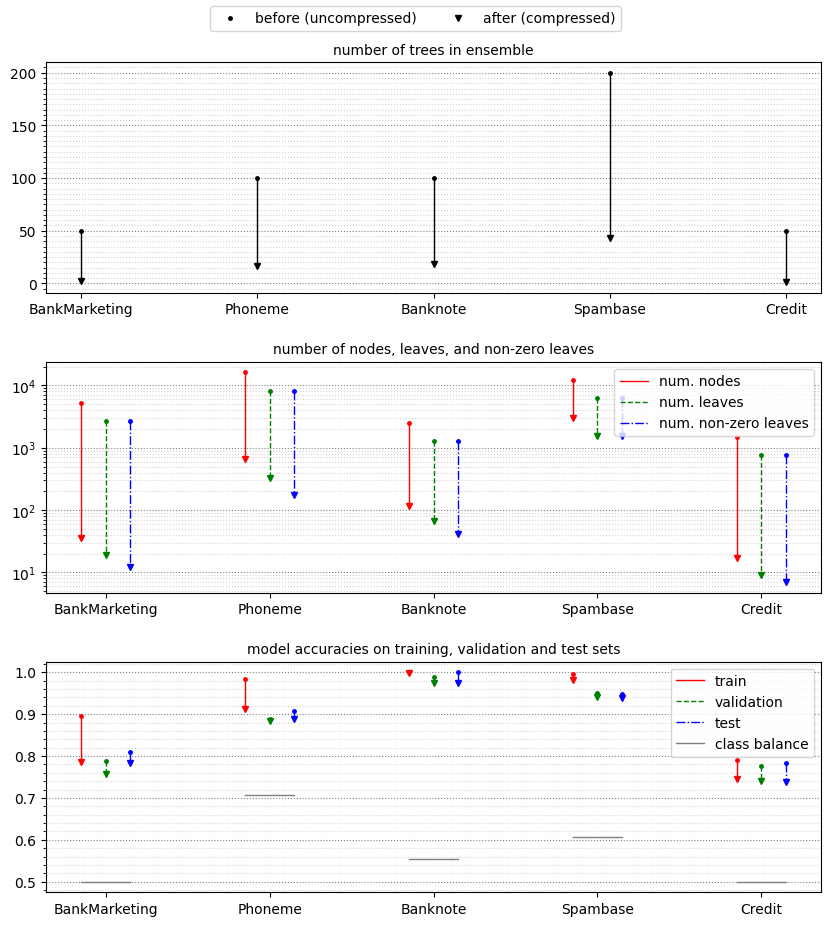

In [12]:
fig, axs = plt.subplots(3, 1, figsize=(10, 10))

axs[0].set_prop_cycle(color=['black'])
for k in [1, 2]:
    axs[k].set_prop_cycle(color=['red', 'green', 'blue'])

#for k, (dname, c) in enumerate(compressed_models.items()):
for k, dname, c, (d, clf, mtrain, mtest, mvalid, params) in zip(range(len(compressed_models)), compressed_models.keys(), compressed_models.values(), best_models.values()):
    before = c.records[0]
    after = c.records[-1]

    i = k-0.15
    j = k+0.15
    
    lk, = axs[0].plot(k, before.ntrees, ".")
    axs[0].plot(k, after.ntrees, "v", color=lk.get_color())
    axs[0].plot([k, k], [before.ntrees, after.ntrees],
                color=lk.get_color())
    
    li, = axs[1].plot(i, before.nnodes, ".")
    axs[1].plot(i, after.nnodes, "v", color=li.get_color())
    axs[1].plot([i, i], [before.nnodes, after.nnodes], "-",
                color=li.get_color())
    
    lk, = axs[1].plot(k, before.nleafs, ".")
    axs[1].plot(k, after.nleafs, "v", color=lk.get_color())
    axs[1].plot([k, k], [before.nleafs, after.nleafs], "--",
                color=lk.get_color())

    lj, = axs[1].plot(j, before.nnz_leafs, ".")
    axs[1].plot(j, after.nnz_leafs, "v", color=lj.get_color())
    axs[1].plot([j, j], [before.nnz_leafs, after.nnz_leafs], "-.",
                color=lj.get_color())
    
    li, = axs[2].plot(i, before.mtrain, ".")
    axs[2].plot(i, after.mtrain, "v", color=li.get_color())
    axs[2].plot([i, i], [before.mtrain, after.mtrain], "-",
                color=li.get_color())
    
    lk, = axs[2].plot(k, before.mvalid, ".")
    axs[2].plot(k, after.mvalid, "v", color=lk.get_color())
    axs[2].plot([k, k], [before.mvalid, after.mvalid], "--",
                color=lk.get_color())

    lj, = axs[2].plot(j, before.mtest, ".")
    axs[2].plot(j, after.mtest, "v", color=lj.get_color())
    axs[2].plot([j, j], [before.mtest, after.mtest], "-.",
                color=lj.get_color())

    class_balance = np.mean(d.y > d.threshold)
    class_balance = max(1-class_balance, class_balance)
    axs[2].plot([i, j], [class_balance, class_balance], "-", c="gray")

for k in [0, 1, 2]:
    axs[k].set_xticks(range(len(compressed_models)))
    axs[k].set_xticklabels(list(compressed_models.keys()))
    axs[k].grid(visible=True, axis="y", ls=":", color="gray", which="major")
    axs[k].grid(visible=True, axis="y", ls=":", color="lightgray", which="minor")

fig.legend([
                Line2D([0], [0], c="black", ls="", marker="."),
                Line2D([0], [0], c="black", ls="", marker="v")
           ], [
                "before (uncompressed)",
                "after (compressed)"
           ], loc="upper center", ncols=2)

axs[1].legend([
                Line2D([0], [0], c="red", ls="-"),
                Line2D([0], [0], c="green", ls="--"),
                Line2D([0], [0], c="blue", ls="-."),
           ], [
                "num. nodes",
                "num. leaves",
                "num. non-zero leaves",
           ])

axs[2].legend([
                Line2D([0], [0], c="red", ls="-"),
                Line2D([0], [0], c="green", ls="--"),
                Line2D([0], [0], c="blue", ls="-."),
                Line2D([0], [0], c="gray", ls="-"),
           ], [
                "train",
                "validation",
                "test",
                "class balance",
           ])

axs[0].set_title("number of trees in ensemble")
axs[1].set_title("number of nodes, leaves, and non-zero leaves")
axs[2].set_title("model accuracies on training, validation and test sets")

axs[1].set_yscale("log")
axs[0].yaxis.set_minor_locator(MultipleLocator(5))
axs[2].yaxis.set_minor_locator(MultipleLocator(0.02))

fig.subplots_adjust(top=0.94, hspace=0.3)

plt.show()

**Tabulate** the same results. We use *before* to indicate the results for the uncompressed model, and *after* to indicate the results for the compressed model.

In [13]:
dnames = list(compressed_models.keys())
index_acc = pd.MultiIndex.from_product((dnames, ["before", "after"]))
df = pd.DataFrame("-", columns=["train", "validation", "test",
                                "ntrees", "nnodes", "nleaves", "nnz_leaves",
                                "nleaf_ratio", "nnz_ratio",
                                "test_ratio"], index=index_acc)

for k, (dname, c) in enumerate(compressed_models.items()):
    before = c.records[0]
    after = c.records[-1]

    rbefore = df.loc[(dname, "before"), :]
    rafter = df.loc[(dname, "after"), :]

    rbefore["train"] = np.round(before.mtrain*100, 1)
    rafter["train"] = np.round(after.mtrain*100, 1)
    rbefore["validation"] = np.round(before.mvalid*100, 1)
    rafter["validation"] = np.round(after.mvalid*100, 1)
    rbefore["test"] = np.round(before.mtest*100, 1)
    rafter["test"] = np.round(after.mtest*100, 1)

    rbefore["ntrees"] = before.ntrees
    rafter[ "ntrees"] = after.ntrees
    rbefore["nnodes"] = before.nnodes
    rafter[ "nnodes"] = after.nnodes
    rbefore["nleaves"] = before.nleafs
    rafter[ "nleaves"] = after.nleafs
    rbefore["nnz_leaves"] = before.nnz_leafs
    rafter[ "nnz_leaves"] = after.nnz_leafs
    rafter[ "nleaf_ratio"] = np.round(before.nleafs / after.nleafs, 2)
    rafter[ "nnz_ratio"] = np.round(before.nnz_leafs / after.nnz_leafs, 2)
    rafter[ "test_ratio"] = 1.0-np.round(after.mtest / before.mtest, 4)

display(df)
df_after = df.xs("after", level=1)
display(df_after[["nleaf_ratio", "nnz_ratio", "test_ratio"]].mean(axis=0))

train validation   test ntrees nnodes nleaves  \
BankMarketing before   89.6       78.8   81.0     50   5290    2670   
              after    78.5       75.7   78.4      2     36      19   
Phoneme       before   98.5       88.9   90.7    100  16110    8105   
              after    91.2       88.3   88.9     17    649     333   
Banknote      before  100.0       98.9  100.0    100   2498    1299   
              after    99.9       97.4   97.4     18    116      67   
Spambase      before   99.5       95.0   94.9    200  12178    6189   
              after    98.0       94.1   93.9     43   3025    1534   
Credit        before   79.1       77.6   78.3     50   1492     771   
              after    74.5       74.1   73.9      1     17       9   

                     nnz_leaves nleaf_ratio nnz_ratio test_ratio  
BankMarketing before       2669           -         -          -  
              after          12      140.53    222.42     0.0321  
Phoneme       before       8101           -         -          -  
              after         172       24.34      47.1     0.0204  
Banknote      before       1299           -         -          -  
              after          42       19.39     30.93     0.0255  
Spambase      before       6178           -         -          -  
              after        1533        4.03      4.03     0.0103  
Credit        before        771           -         -          -  
              after           7       85.67    110.14     0.0562

nleaf_ratio    54.792
nnz_ratio      82.924
test_ratio     0.0289
dtype: object

## Verifiability: how many output configurations (OCs)?

If we can enumerate all the OCs in 5 minutes, then we consider the models tractably verifiable.
We can enumerate all the output configurations using [Veritas](https://github.com/laudv/veritas).

In [9]:
for k, (dname, c) in enumerate(compressed_models.items()):
    before = c.records[0]
    after = c.records[-1]

    print("*", dname)
    at_pruned = after.at

    config = veritas.Config(veritas.HeuristicType.MAX_OUTPUT)
    config.stop_when_optimal = False
    search = config.get_search(at_pruned)

    while search.steps(1000) != veritas.StopReason.NO_MORE_OPEN \
            and search.time_since_start() < 5*60.0:
        pass
        #print("Veritas", search.num_solutions(), search.num_open())
    print("  number of OCs", search.num_solutions())
    print("  number of unexplored open states (should be 0)", search.num_open())


* BankMarketing
  number of OCs 104
  number of unexplored open states (should be 0) 0
* Phoneme


KeyboardInterrupt: 

## Checking robustness on the test set

We compute the adversarial accuracy on the original model, and on the pruned model.
We ask the questions:

- How much faster can we do this on the pruned dataset?
- How does pruning affect the robustness of the models?

In [ ]:
delta = 0.05
robustness = {}

for dname, c, (d, clf, mtrain, mtest, mvalid, params) in zip(compressed_models.keys(),
                                                             compressed_models.values(),
                                                             best_models.values()):
    dtrain, dtest = d.train_and_test_fold(0)
    dtrain, dvalid = dtrain.train_and_test_fold(0)
    before = c.records[0]
    after = c.records[-1]

    #print()
    #veritas.test_conversion(before.at, dtest.X.to_numpy(), clf.predict_proba(dtest.X)[:,1])

    print("*", dname)

    total_time = [0.0, 0.0]
    count = [0, 0]
    count_wrong = [0, 0]
    count_nonrobust = [0, 0]
    count_to = [0, 0]

    for i in range(min(2000, dtest.X.shape[0])):
        example = dtest.X.iloc[i, :].to_numpy()
        true_label = int(dtest.y.iloc[i])
        prune_box = [veritas.Interval(x-delta, x+delta) for x in example]

        for k, at in enumerate([before.at, after.at]):
            count[k] += 1
            pred_label = int(at.predict(example)[0][0] >= .5)
    
            if true_label != pred_label:
                count_wrong[k] += 1
                continue
    
            heur = veritas.HeuristicType.MIN_OUTPUT if pred_label \
                   else veritas.HeuristicType.MAX_OUTPUT
    
            config = veritas.Config(heur)
            config.ignore_state_when_worse_than = 0.0
            search = config.get_search(at, prune_box)
    
            stop_reason = veritas.StopReason.NONE
        
            while search.num_solutions() == 0 \
                    and stop_reason == veritas.StopReason.NONE \
                    and search.time_since_start() < 5.0:
                stop_reason = search.steps(1000)
    
            total_time[k] += search.time_since_start()
    
            raw_pred = 0.0
            if search.num_solutions() > 0:
                adv_example = veritas.get_closest_example(search.get_solution(0), example, 1e-4)
                wrong_label = int(at.predict(adv_example)[0][0] >= .5)
                #data = np.vstack([example.reshape(1, -1), adv_example.reshape(1, -1)])
                #raw_pred_example, raw_pred_adv = at.eval(data)[:, 0]
                assert wrong_label != pred_label
                count_nonrobust[k] += 1
            if search.time_since_start() >= 5.0:
                count_to[k] += 1
        
        #print(i, f"lab={label}, adv={wrong_label} {raw_pred:5.3f}", search.num_solutions())
    print(f"  TOTAL TIME before {total_time[0]:.4f}s after {total_time[1]:.4f}s",
          f"({total_time[0]/total_time[1]:.1f}x)")
    print(f"  ROBUSTNESS before nonrobust {count_nonrobust[0]:4d}, incorrect {count_wrong[0]:4d}, timeout {count_to[0]:4d} ({count[0]})",
          f"adv acc={100*(1.0-(count_nonrobust[0]+count_wrong[0])/(count[0])):.1f}%")
    print(f"              after nonrobust {count_nonrobust[1]:4d}, incorrect {count_wrong[1]:4d}, timeout {count_to[1]:4d} ({count[1]})",
          f"adv acc={100*(1.0-(count_nonrobust[1]+count_wrong[1])/(count[1])):.1f}%")

    robustness[dname] = [{
        "total_time": total_time[k],
        "count_nonrobust": count_nonrobust[k],
        "count_wrong": count_wrong[k],
        "count_to": count_to[k],
        "count": count[k],
    } for k in range(2)]

In [ ]:
# Tabulate
dnames = list(compressed_models.keys())
index_acc = pd.MultiIndex.from_product((dnames, ["before", "after"]))
dfrob = pd.DataFrame("-", columns=["wrong", "nonrobust", "total", "adv.acc", "time", "speedup"], index=index_acc)

for k, (dname, results) in enumerate(robustness.items()):
    before = c.records[0]
    after = c.records[-1]

    for j, jj, res in zip(range(2), ["before", "after"], results):
        r = dfrob.loc[(dname, jj), :]
        rafter = dfrob.loc[(dname, "after"), :]

        r["wrong"] = res["count_wrong"]
        r["nonrobust"] = res["count_nonrobust"]
        r["total"] = res["count"]
        #r["timeout"] = res["count_to"]
        r["adv.acc"] = np.round(100.0 - 100*(res["count_wrong"] + res["count_nonrobust"]) / res["count"], 1)
        r["time"] = np.round(res["total_time"], 2)

    dfrob.loc[(dname, "after"), "speedup"] = np.round(results[0]["total_time"] / results[1]["total_time"], 1)

display(dfrob)

We again use *before* to indicate the results for the uncompressed model, and *after* to indicate the results for the compressed model.